In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [107]:
def load_file(name): 
    #data = np.loadtxt('data/Test2/' + name + '.csv',skiprows=2,delimiter=',').T 
    data = np.loadtxt('E:\Eksperimentel_fysik\Michelson_interferometer\Dag2_2\\' + name + '.csv',skiprows=2,delimiter=',').T
    return data

def find_slopes(top, bot):
    rise = []
    fall = []
    first_rising = top[0] > bot[0]          
    last_rising = top[-1] > bot[-1]
    max_len = max(len(top), len(bot))
    if first_rising and last_rising:
        fall = [(top[i], bot[i+1]) for i in range(max_len - 1)]
        rise = [(bot[i], top[i] ) for i in range(max_len)]
    elif first_rising and not last_rising:
        fall = [(top[i], bot[i+1]) for i in range(max_len - 1)]
        rise = [(bot[i],top[i]) for i in range(max_len - 1)]
    elif not first_rising and not last_rising:
        fall = [(top[i], bot[i]) for i in range(max_len)]
        rise = [(bot[i],top[i+1]) for i in range(max_len - 1)]
    elif not first_rising and last_rising:
        fall = [(top[i], bot[i]) for i in range(max_len - 1)]
        rise = [(bot[i],top[i+1]) for i in range(max_len -1)]
    else:
        print('You fucked it up fam')
    return rise, fall

def slope_intensity(slope,volt,intensity): 
    volt_slope = volt[slope[0]:slope[1]+1]
    intensity_slope = intensity[slope[0]:slope[1]+1]
    unique_volt = sorted(list(set(volt_slope)))
    slope_int = [np.mean([intensity_slope[i] for i,volt_j in enumerate(volt_slope) if volt_j == volt_i]) for volt_i in unique_volt]
    return slope_int, unique_volt

def mean_slopes(slope_list,volt,intensity): 
    slope_ints = []
    for slope in slope_list: 
        s_int,unique_volt = slope_intensity(slope,volt,intensity)
        slope_ints.append(s_int)
    mean_slope = np.mean(slope_ints,axis=0)
    error_slope = np.std(slope_ints,axis=0,ddof=1)/np.sqrt(len(slope_ints))
    return unique_volt,mean_slope,error_slope

def mean_several_files(max_file_num,file_name): 
    rise_ints = []
    fall_ints = []
    for i in range(max_file_num): 
        print(i)
        
        if i < 9: 
            time,intensity,volt = load_file(f'{file_name}_0{i+1}')
        else: 
            time,intensity,volt = load_file(f'{file_name}_{i+1}')
        if len(volt) < 1000:
            continue 
        else: 
            max_peaks = find_peaks(volt,distance=1000,width=100)[0]
            min_peaks = find_peaks(-1*volt,distance=1000,width=100)[0]
            rise_slopes,fall_slopes = find_slopes(max_peaks,min_peaks)

            for rise in rise_slopes:
                s_int,unique_volt = slope_intensity(rise,volt,intensity)
                if len(unique_volt) == 105:
                    rise_ints.append(s_int)
                #print(f'Rise:{len(unique_volt)}')
                
            for fall in fall_slopes: 
                s_int,unique_volt = slope_intensity(fall,volt,intensity)
                if len(unique_volt) == 105:
                    fall_ints.append(s_int)
                #print(f'Fall:{len(unique_volt)}')
            
    rise_mean = np.mean(rise_ints,axis=0)
    rise_error = np.std(rise_ints,ddof=1,axis=0)/np.sqrt(len(rise_ints))
    fall_mean = np.mean(fall_ints,axis=0)
    fall_error = np.std(fall_ints,ddof=1,axis=0)/np.sqrt(len(fall_ints))
    return unique_volt,rise_mean,rise_error,fall_mean,fall_error

In [83]:
#Funktioner til at finde peaks
def slope_max(slope,volt,intensity): 
    volt_slope = volt[slope[0]:slope[1]+1]
    intensity_slope = intensity[slope[0]:slope[1]+1]
    unique_volt = np.array(sorted(list(set(volt_slope))))
    slope_int = np.array([np.mean([intensity_slope[i] for i,volt_j in enumerate(volt_slope) if volt_j == volt_i]) for volt_i in unique_volt])
    max_peaks = find_peaks(slope_int,distance=1,width=1)[0]
    min_peaks = find_peaks(-1*slope_int,distance=1,width=1)[0]
    int_to_sort = np.append(slope_int[max_peaks],slope_int[min_peaks])
    volt_to_sort = np.append(unique_volt[max_peaks],unique_volt[min_peaks])
    filter_list = np.argsort(volt_to_sort)
    return int_to_sort[filter_list],volt_to_sort[filter_list]


def max_several_files(max_file_num,file_name): 
    rise_max = []
    fall_max = []
    rise_volts = []
    fall_volts = []
    
    for i in range(max_file_num): 
        print(i)
        
        if i < 9: 
            time,intensity,volt = load_file(f'{file_name}_0{i+1}')
        else: 
            time,intensity,volt = load_file(f'{file_name}_{i+1}')
        if len(volt) < 1000:
            continue 
        else: 
            max_peaks = find_peaks(volt,distance=1000,width=100)[0]
            min_peaks = find_peaks(-1*volt,distance=1000,width=100)[0]
            rise_slopes,fall_slopes = find_slopes(max_peaks,min_peaks)

            for rise in rise_slopes:
                int_max,volt_max = slope_max(rise,volt,intensity)
                if len(volt_max) == 10:
                    rise_max.append(int_max)
                    rise_volts.append(volt_max)
                #print(f'Rise:{len(volt_max)}')
                
            for fall in fall_slopes: 
                int_max,volt_max = slope_max(fall,volt,intensity)
                if len(volt_max) == 10:
                    fall_max.append(int_max)
                    fall_volts.append(volt_max)
                #print(f'Fall:{len(volt_max)}')
            
    rise_mean = np.mean(rise_max,axis=0)
    rise_error = np.std(rise_max,ddof=1,axis=0)/np.sqrt(len(rise_max))
    fall_mean = np.mean(fall_max,axis=0)
    fall_error = np.std(fall_max,ddof=1,axis=0)/np.sqrt(len(fall_max))
    volt_rise_mean = np.mean(rise_volts,axis=0)
    rise_volt_error = np.std(rise_volts,ddof=1,axis=0)/np.sqrt(len(rise_volts))
    volt_fall_mean = np.mean(fall_volts,axis=0)
    fall_volt_error = np.std(fall_volts,ddof=1,axis=0)/np.sqrt(len(fall_volts))
    print(f'Nr. of datapoints: {len(rise_max)}')
    return volt_rise_mean,rise_volt_error,volt_fall_mean,fall_volt_error,rise_mean,rise_error,fall_mean,fall_error


In [109]:
volt_rise,volt_rise_error,volt_fall,volt_fall_error,rise_max,\
rise_max_error,fall_max,fall_max_error = max_several_files(10,'Dag2_2')

0
1
2
3
4
5
6
7
8
9
Nr. of datapoints: 45


In [87]:
v_list,rise_mean,rise_error,fall_mean,fall_error = mean_several_files(2,'Dag2_2')

0
1


[0.01152737 0.00886436 0.0073408  0.00904685 0.00889941 0.00379267
 0.00679409 0.00652678 0.00422107 0.01996548]


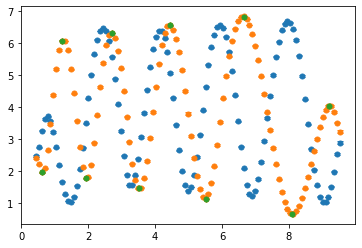

In [98]:
v_list = np.array(v_list)
rise_mean = np.array(rise_mean)

plt.errorbar(v_list,rise_mean,yerr=rise_error,fmt='o',ms=5,lw=2,capsize=3)
plt.errorbar(v_list,fall_mean,yerr=fall_error,fmt='o',ms=5,lw=2,capsize=3)
plt.errorbar(volt_fall,fall_max,xerr=volt_fall_error,yerr=fall_max_error,fmt='o',ms=5,lw=2,capsize=3)

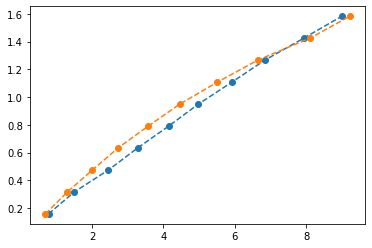

In [112]:
lambd = 633*1e-3 #µm
dl_rise = [(i+1)*lambd/4 for i in range(len(rise_max))]
dl_fall = [(i+1)*lambd/4 for i in range(len(fall_max))]

plt.plot(volt_rise,dl_rise,'--o')
plt.plot(volt_fall,dl_fall,'--o')

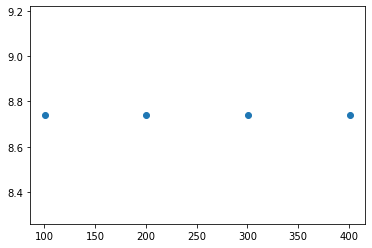

In [54]:
max_peaks = find_peaks(volt,distance=1000,width=100)[0]
min_peaks = find_peaks(-1*volt,distance=100,width=100)[0]

rise,fall = find_slopes(max_peaks,min_peaks)
test = fall[1]

plt.plot(time[max_peaks],volt[max_peaks],'o')
#plt.plot(time[test[0]:test[1]+1],volt[test[0]:test[1]+1])
#plt.plot(volt[test[0]:test[1]+1],intensity[test[0]:test[1]+1],'.')
#plt.plot(volt[test1[0]:test1[1]+1],intensity[test1[0]:test1[1]+1],'.')

In [8]:
v_list,mean,error = mean_slopes(fall,volt,intensity)